In [3]:
import os
import math
import numpy as np
import pathlib

from Bio import Entrez
from Bio import SeqIO
from Bio.Align import PairwiseAligner, substitution_matrices
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt


Organisms are retrieved from Functional and genetic analysis of viral receptor ACE2 orthologs reveals a broad potential host range
of SARS-CoV-2 paper. List of accession numbers are shown as follows. Only 11 will be retrieved inclusive of Human ortholog.

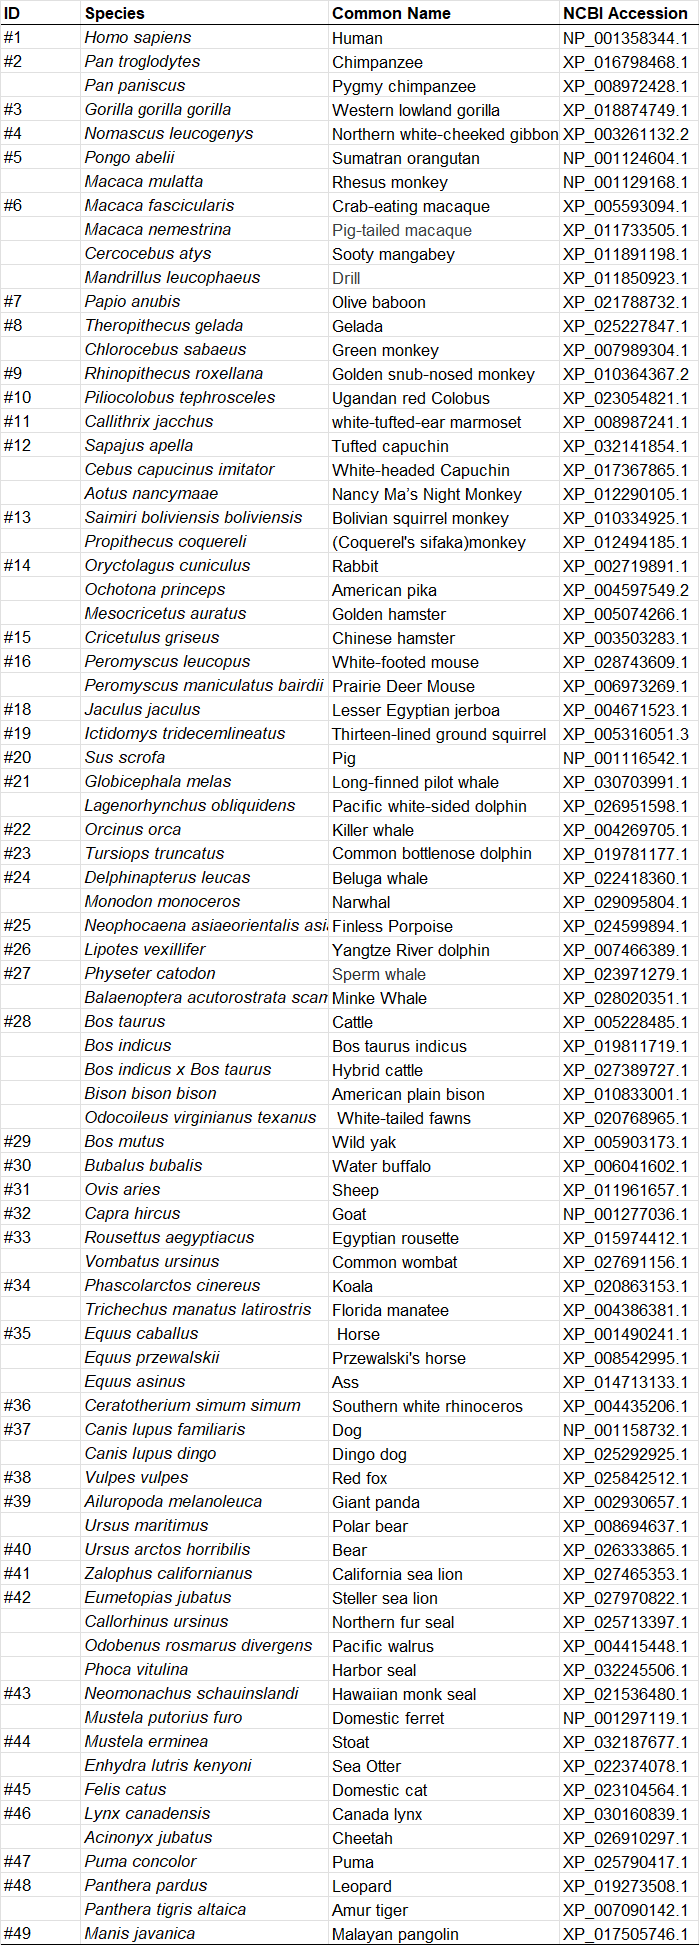

In [21]:
# Correct accession numbers for the sequences
accession_dict = {
    "Homo sapiens (Human)": "NP_001358344.1",
    "Pan troglodytes (Chimpanzee)": "XP_016798468.1",
    "Callithrix jacchus (Marmoset)": "XP_008987241.1",
    "Felis catus (Cat)": "XP_023104564.1",
    "Canis lupus familiaris (Dog)": "NP_001158732.1",
    "Mustela putorius furo (ferret)": "NP_001297119.1",
    "Rousettus aegyptiacus (Bat)": "XP_015974412.1",
    "Manis javanica (Pangolin)": "XP_017505746.1",
    "Sus scrofa (Pig)": "NP_001116542.1",
    "Peromyscus leucopus(Mouse)": "XP_028743609.1",
    "Bos taurus (Cattle)": "XP_005228485.1",
}

In [22]:
fasta_file = "ace2_orthologs.fasta"
accession_vals = list(accession_dict.values())

try:
    handle = Entrez.efetch(db="protein", id=accession_vals, rettype="fasta", retmode="text")
    data = handle.read()
    handle.close()
    pathlib.Path(fasta_file).write_text(data)
    print(f"Saved fasta file to {fasta_file}")
except Exception as e:
    print(f"Errror occured: {e}")

c:\Python312\Lib\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


Saved fasta file to ace2_orthologs.fasta


In [23]:
fasta_filename = "ace2_orthologs.fasta"
sequences_dict = {}
try:
    with open(fasta_filename, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            common_name = None
            for name, acc in accession_dict.items():
                if acc in record.id:
                    common_name = name
                    break
            if common_name:
                record.id = common_name
                record.description = f"{common_name} ACE2"
                sequences_dict[common_name] = record

    print(">>> Successfully loaded sequences from file. Verification:")
    print("---------------------------------------------------------")
    for name, record in sequences_dict.items():
        print(f"  - {name:<12} ({accession_dict[name]}): {len(record.seq)} amino acids")
    print("---------------------------------------------------------")

except FileNotFoundError:
    print(f"\n!!! Error: The file '{fasta_filename}' was not found. Please run the download step again.")

>>> Successfully loaded sequences from file. Verification:
---------------------------------------------------------
  - Homo sapiens (Human) (NP_001358344.1): 805 amino acids
  - Pan troglodytes (Chimpanzee) (XP_016798468.1): 805 amino acids
  - Callithrix jacchus (Marmoset) (XP_008987241.1): 805 amino acids
  - Felis catus (Cat) (XP_023104564.1): 807 amino acids
  - Canis lupus familiaris (Dog) (NP_001158732.1): 804 amino acids
  - Mustela putorius furo (ferret) (NP_001297119.1): 805 amino acids
  - Rousettus aegyptiacus (Bat) (XP_015974412.1): 805 amino acids
  - Manis javanica (Pangolin) (XP_017505746.1): 805 amino acids
  - Sus scrofa (Pig) (NP_001116542.1): 805 amino acids
  - Peromyscus leucopus(Mouse) (XP_028743609.1): 805 amino acids
  - Bos taurus (Cattle) (XP_005228485.1): 811 amino acids
---------------------------------------------------------


In [34]:
aligner = PairwiseAligner()
aligner.mode = 'global'
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.open_gap_score = -5
aligner.extend_gap_score = -3

TODO: add explanation here

this website says na it's best to use blosum62 for protein 
https://www.nlm.nih.gov/ncbi/workshops/2023-08_BLAST_evol/blast_score.html

this paper says what affine scores should be set for blosum62
Empirical determination of effective gap penalties for sequence comparison
10.1093/bioinformatics/18.11.1500

In [35]:
print("Performing pairwise alignments against Human ACE2 and analyzing key residues\n")

alignments_dict = {}
human_record = sequences_dict["Homo sapiens (Human)"]
key_positions = [31, 35, 38, 41, 42, 82, 353]
key_residues = {}
identity_scores = {}

for name, record in sequences_dict.items():
    if name == "Homo sapiens (Human)":
        continue

    alignment = aligner.align(human_record.seq, record.seq)[0]
    alignments_dict[name] = alignment

    human_aligned_seq = alignment[0]
    other_aligned_seq = alignment[1]

    # Identity %
    identity = (np.array(list(human_aligned_seq)) == np.array(list(other_aligned_seq))).sum()
    percent_identity = (identity / alignment.shape[1]) * 100
    identity_scores[name] = (alignment.score, percent_identity)

    # Key residues
    map_human_to_alignment = [i for i, char in enumerate(human_aligned_seq) if char != '-']
    residues = {}
    for pos in key_positions:
        if pos - 1 < len(map_human_to_alignment):
            aligned_index = map_human_to_alignment[pos - 1]
            residues[pos] = other_aligned_seq[aligned_index]
        else:
            residues[pos] = "-"
    key_residues[name] = residues
print ("All pairwise alignments complete")

Performing pairwise alignments against Human ACE2 and analyzing key residues

All pairwise alignments complete


In [36]:
# table 1: alignment scores and identity
print("-" * 60)
print(f"{'Species':<30} | {'Score':>7} | {'Identity (%)':>12}")
print("-" * 60)

for name, (score, identity) in identity_scores.items():
    print(f"{name:<30} | {score:7.1f} | {identity:11.2f}%")

print(f"{'Human':<30} | {'-':>7} | {'-':>12}")
print("-" * 60)


------------------------------------------------------------
Species                        |   Score | Identity (%)
------------------------------------------------------------
Pan troglodytes (Chimpanzee)   |  4253.0 |       99.01%
Callithrix jacchus (Marmoset)  |  3957.0 |       91.68%
Felis catus (Cat)              |  3697.0 |       84.63%
Canis lupus familiaris (Dog)   |  3639.0 |       83.48%
Mustela putorius furo (ferret) |  3629.0 |       82.63%
Rousettus aegyptiacus (Bat)    |  3482.0 |       78.88%
Manis javanica (Pangolin)      |  3679.0 |       84.84%
Sus scrofa (Pig)               |  3567.0 |       81.37%
Peromyscus leucopus(Mouse)     |  3633.0 |       83.11%
Bos taurus (Cattle)            |  3441.0 |       78.38%
Human                          |       - |            -
------------------------------------------------------------


# TO DO PARAPHRASE
Our analysis revealed that 80 ACE2 orthologs from 295 species exactly contained the relevant amino acids at positions 31, 35, 38, 82, and 353, which we deduce would allow them to function as SARS-CoV-2 receptors 

Based on the structures of SARS-CoV-2 S protein complexed with human ACE2, five critical amino acid residues of human ACE2 (31K, 35E, 38D, 82M, or 353K) constitute two virusbinding hotspots (31K hotspot and 353K hotspot) that are indispensable for interaction with S protein and viral entry (22). The 31K hotspot consists of a salt bridge between 31K and 35E, and the 353K hotspot consists of a salt bridge between 353K and 38D; 82M is critical to stabilize 31K hotspot through hydrophobic interaction with 486F of SARS-CoV-2 RBD (22, 28).

Y41 and Q42 in human ACE2 are responsible for the formation of hydrogen bonds with S protein and are highly conserved 
across all other species [to paraphrase].

Note the residues for Marmoset (H, E) at positions 41 and 42, which differ from the Human (Y, Q), as highlighted in the PNAS paper.
[FROM STUDY]

In [48]:
# table 2: residues
print("\nKey Residues:")
print("-" *100)
print(f"{'Species':<30} | {'Pos 31':>7} | {'Pos 35':>7} | {'Pos 38':>7} | {'Pos 41':>7} | {'Pos 42':>7} | {'Pos 82':>7} | {'Pos 353':>7}")
print("-" * 100)

for name, residues in key_residues.items():
    print(f"{name:<30}"
          + "".join(f" | {residues.get(pos, '-'):>7}" for pos in [31, 35, 38, 41, 42, 82, 353]))

print(f"{'Human':<30}"
      + f" | {human_record.seq[30]:>7} | {human_record.seq[34]:>7} | {human_record.seq[38]:>7} | {human_record.seq[40]:>7}"
      + f" | {human_record.seq[41]:>7} | {human_record.seq[81]:>7} | {human_record.seq[352]:>7}")
print("-" * 100)

print("\nDiscussion Point: For example, Y41 and Q42 in human ACE2 are responsible for the formation of hydrogen bonds with S protein and are highly conserved "
      "\nacross all other species [to paraphrase].")
print("\nNote the residues for Marmoset (H, E) at positions 41 and 42, which differ from the Human (Y, Q), as highlighted in the PNAS paper.")


Key Residues:
----------------------------------------------------------------------------------------------------
Species                        |  Pos 31 |  Pos 35 |  Pos 38 |  Pos 41 |  Pos 42 |  Pos 82 | Pos 353
----------------------------------------------------------------------------------------------------
Pan troglodytes (Chimpanzee)   |       K |       E |       D |       Y |       Q |       M |       K
Callithrix jacchus (Marmoset)  |       K |       E |       D |       H |       E |       T |       K
Felis catus (Cat)              |       K |       E |       E |       Y |       Q |       T |       K
Canis lupus familiaris (Dog)   |       K |       E |       E |       Y |       Q |       T |       K
Mustela putorius furo (ferret) |       K |       E |       E |       Y |       Q |       T |       K
Rousettus aegyptiacus (Bat)    |       K |       E |       D |       Y |       Q |       T |       K
Manis javanica (Pangolin)      |       K |       E |       E |       Y |    

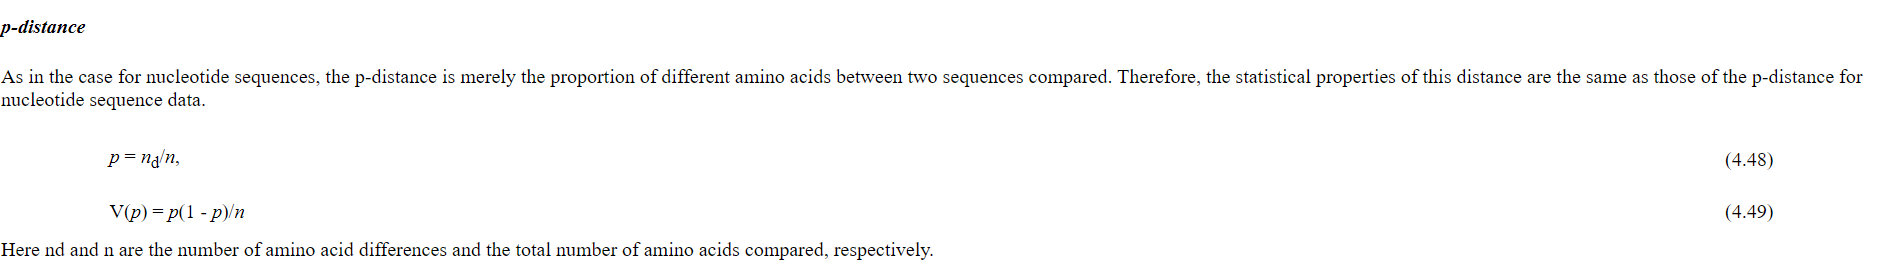

In [38]:
def compute_p_distance(seq1, seq2):
    mismatches = 0
    aligned_len_no_gaps = 0
    for i in range(len(seq1)):
        if seq1[i] != '-' and seq2[i] != '-':
            aligned_len_no_gaps += 1
            if seq1[i] != seq2[i]:
                mismatches += 1
    
    if aligned_len_no_gaps == 0:
        return 0.0

    # p-distance is the proportion of non-identical sites
    p_dist = mismatches / aligned_len_no_gaps
    return p_dist

In [39]:
species_names = list(sequences_dict.keys())
num_species = len(species_names)

print("\nP-distance to Human:")
print("-" * 30)
print(f"{'Species':<30} | {'p-distance':>10}")
print("-" * 30)

for species in species_names:
    if species == "Homo sapiens (Human)":
        continue
    # aligned sequences from the alignment Human vs species
    aligned_human = alignments_dict[species][0]
    aligned_other = alignments_dict[species][1]

    p_dist = compute_p_distance(aligned_human, aligned_other)
    print(f"{species:<30} | {p_dist:10.4f}")




P-distance to Human:
------------------------------
Species                        | p-distance
------------------------------
Pan troglodytes (Chimpanzee)   |     0.0099
Callithrix jacchus (Marmoset)  |     0.0832
Felis catus (Cat)              |     0.1516
Canis lupus familiaris (Dog)   |     0.1642
Mustela putorius furo (ferret) |     0.1716
Rousettus aegyptiacus (Bat)    |     0.2112
Manis javanica (Pangolin)      |     0.1516
Sus scrofa (Pig)               |     0.1863
Peromyscus leucopus(Mouse)     |     0.1689
Bos taurus (Cattle)            |     0.2045


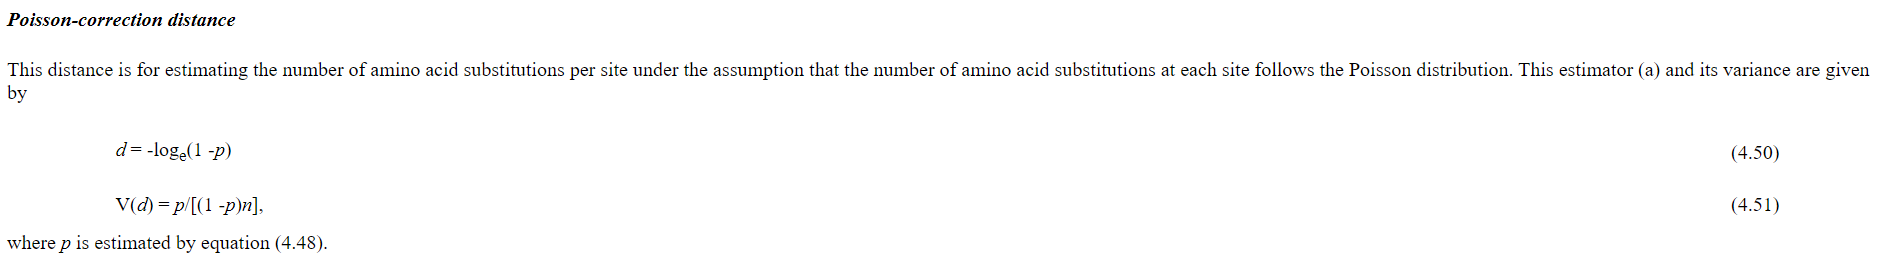

In [40]:
def compute_poisson_distance(seq1, seq2):
    p_dist = compute_p_distance(seq1, seq2)
    if p_dist >= 1.0:
        return float('inf')  # Avoid log(0) or negative values
    return -math.log(1 - p_dist)


TODO: why you need poisson

In [41]:
species_names = list(sequences_dict.keys())
num_species = len(species_names)

print("\nPoisson corrected distance to Human:")
print("-" * 30)
print(f"{'Species':<30} | {'poisson-distance':>10}")
print("-" * 30)

for species in species_names:
    if species == "Homo sapiens (Human)":
        continue
    aligned_human = alignments_dict[species][0]
    aligned_other = alignments_dict[species][1]

    p_dist = compute_poisson_distance(aligned_human, aligned_other)
    print(f"{species:<30} | {p_dist:10.4f}")




Poisson corrected distance to Human:
------------------------------
Species                        | poisson-distance
------------------------------
Pan troglodytes (Chimpanzee)   |     0.0100
Callithrix jacchus (Marmoset)  |     0.0869
Felis catus (Cat)              |     0.1643
Canis lupus familiaris (Dog)   |     0.1793
Mustela putorius furo (ferret) |     0.1883
Rousettus aegyptiacus (Bat)    |     0.2372
Manis javanica (Pangolin)      |     0.1643
Sus scrofa (Pig)               |     0.2062
Peromyscus leucopus(Mouse)     |     0.1851
Bos taurus (Cattle)            |     0.2288


to do a dendogram, you need pairwise sequence alignment of all-all, not just one species-human

In [42]:
distances = np.zeros((num_species, num_species))  # initialize full matrix

for i in range(num_species):
    for j in range(i):  # only compute for lower triangle
        species1 = species_names[i]
        species2 = species_names[j]

        record1 = sequences_dict[species1]
        record2 = sequences_dict[species2]

        alignment = aligner.align(record1.seq, record2.seq)[0]
        corrected_distance = compute_poisson_distance(alignment[0], alignment[1])

        distances[i][j] = corrected_distance
        distances[j][i] = corrected_distance  # mirror

A->B, B->A

In [43]:
distances

array([[0.        , 0.0099876 , 0.08689845, 0.16434742, 0.17934093,
        0.1883096 , 0.23721728, 0.16434742, 0.20620704, 0.18505822,
        0.22877032],
       [0.0099876 , 0.        , 0.08825439, 0.16288436, 0.17934093,
        0.18381521, 0.23564371, 0.16288436, 0.20620704, 0.18955261,
        0.23033895],
       [0.08689845, 0.08825439, 0.        , 0.1865541 , 0.20649192,
        0.20649192, 0.24989574, 0.1865541 , 0.21849598, 0.18805223,
        0.24616207],
       [0.16434742, 0.16288436, 0.1865541 , 0.        , 0.10204925,
        0.11298092, 0.21540956, 0.13566587, 0.17909695, 0.20039434,
        0.21167589],
       [0.17934093, 0.17934093, 0.20649192, 0.10204925, 0.        ,
        0.10896013, 0.22034895, 0.14013561, 0.19735943, 0.20677758,
        0.21351465],
       [0.1883096 , 0.18381521, 0.20649192, 0.11298092, 0.10896013,
        0.        , 0.20677758, 0.14405687, 0.17612959, 0.20191525,
        0.22595649],
       [0.23721728, 0.23564371, 0.24989574, 0.21540956, 0.

TO DO: NOT SURE IF THIS IS CORRECT
Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

WIKIPEDIA REFERENCE PROVIDED BY DOC:
https://en.wikipedia.org/wiki/UPGMA

In [44]:
condensed = squareform(distances)

In [45]:
condensed

array([0.0099876 , 0.08689845, 0.16434742, 0.17934093, 0.1883096 ,
       0.23721728, 0.16434742, 0.20620704, 0.18505822, 0.22877032,
       0.08825439, 0.16288436, 0.17934093, 0.18381521, 0.23564371,
       0.16288436, 0.20620704, 0.18955261, 0.23033895, 0.1865541 ,
       0.20649192, 0.20649192, 0.24989574, 0.1865541 , 0.21849598,
       0.18805223, 0.24616207, 0.10204925, 0.11298092, 0.21540956,
       0.13566587, 0.17909695, 0.20039434, 0.21167589, 0.10896013,
       0.22034895, 0.14013561, 0.19735943, 0.20677758, 0.21351465,
       0.20677758, 0.14405687, 0.17612959, 0.20191525, 0.22595649,
       0.20620704, 0.22159196, 0.26597325, 0.27201165, 0.19105524,
       0.18805223, 0.21971622, 0.21386991, 0.16207895, 0.23505965])

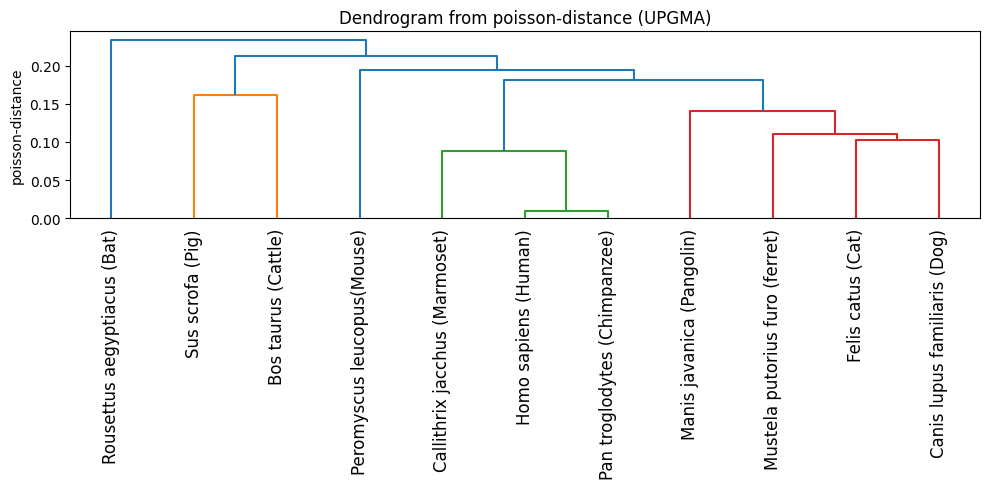

In [46]:
linkage_matrix = linkage(condensed, method='average')  # UPGMA

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=species_names, leaf_rotation=90)
plt.title("Dendrogram from poisson-distance (UPGMA)")
plt.ylabel("poisson-distance")
plt.tight_layout()
plt.show()
